In [7]:
WEB_SITE_NAME = 'Entekhab.ir'
TEST_SET_SIZE = 0.62 # max = 1
TEST_SET_SIZE1 = 0.59 # max = 1

In [8]:
WEB_SITE_matrix = '../../models/' + WEB_SITE_NAME + '/view_matrix/lil_matrix.npz'
WEB_SITE_CONTENT_CSV = '../../models/content/' + WEB_SITE_NAME + '.csv'
WEB_SITE_itemindexer = '../../models/' + WEB_SITE_NAME + '/view_matrix/item_indexer.indexer'
WEB_SITE_userindexer = '../../models/' + WEB_SITE_NAME + '/view_matrix/user_indexer.indexer'
SAVING1 = './alisResult/' + WEB_SITE_NAME + '/ALS/ali_item_indexer_factorized.indexer'
SAVING2 = './alisResult/' + WEB_SITE_NAME + '/ALS/ali_user_indexer_factorized.indexer'
SAVING3 = './alisResult/' + WEB_SITE_NAME + '/ALS/ali_items_vectors.npy'
SAVING4 = './alisResult/' + WEB_SITE_NAME + '/ALS/ali_users_vectors.npy'
RESULTS_PATH = RESULTS = '../results/annoy_opt/' + WEB_SITE_NAME + '/'

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from tqdm import tqdm

import timeit
import time
import math

# ./indexer
from indexer import AppendIndexer
import ALS

# Annoy
from annoy import AnnoyIndex

#SKLearn 
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import average_precision_score
from sklearn.metrics import pairwise_distances

# scipy
from scipy.spatial import distance
from scipy.sparse import lil_matrix

In [10]:
def calc_acc(annoy_indices, knn_indices, k):
    aa = []
    for i in range(len(annoy_indices)):
        b = []
        for j in annoy_indices[i][1:]:
            if j in knn_indices[i][:k]:
                b.append(1)
            else:
                b.append(0)
        aa.append(b)
    res2 = []
    for a in aa:
        acc2 = 0
        for i in range(len(a)):
            acc2 += a[i]
        if not len(a):
            res2.append(0)
        else:
            res2.append(acc2/len(a))
    return np.array(res2).mean()
def calc_nDCG(annoy_indices, knn_indices, k, discount = 3):
    aa = []
    for i in range(len(annoy_indices)):
        b = []
        for j in annoy_indices[i][1:]:
            if j in knn_indices[i][:k]:
                b.append(1)
            else:
                b.append(0)
        aa.append(b)
    res = []
    for a in aa:
        acc = 0
        for i in range(len(a)):
            acc += a[i]/math.log(i+7, 7)
        if not len(a):
            res.append(0)
        else:
            res.append(acc/len(a))
    return np.array(res).mean()


## loading data

In [11]:
WEBSITE_content = pd.read_csv(WEB_SITE_CONTENT_CSV)
WEBSITE_content.head(5)

,Unnamed: 0,id,created,content_vector,title,cleaned_url,website_id,included,is_amp,has_image_meta,has_title_meta,subdomain_id,title_vector,image_id,cats,features_extracted,page_identifier
0,5,8475221,2020-12-01 18:40:09.766526+03:30,"{1.03425741195679,-0.995323657989502,-0.525914...",موگرینی: اتحادیه اروپا می‌تواند کاری کند که بر...,entekhab.ir/fa/news/587656/%D9%85%D9%88%DA%AF%...,2,t,f,t,t,73,"{1.35345149040222,-1.09627091884613,-1.1427240...",3150565.0,{15},f,47285378
1,6,8475260,2020-12-01 18:45:07.809365+03:30,"{0.977447152137756,-0.836534082889557,0.622178...",دو نماینده مجلس در خصوص تصویب کلیات طرح اقدام ...,entekhab.ir/fa/news/587654/%D8%AF%D9%88-%D9%86...,2,t,f,t,t,73,"{1.14356899261475,-0.720115184783936,0.1236076...",3150586.0,{15},f,47287000
2,7,8475261,2020-12-01 18:45:07.810706+03:30,"{0.93014258146286,0.118128687143326,-1.5581080...",استقلال ۰ - ۰ پیکان / تقابل شاگردان تارتار و ف...,entekhab.ir/fa/news/587653/%D8%A7%D8%B3%D8%AA%...,2,t,f,t,t,73,"{0.793892502784729,-0.314135849475861,-1.48226...",3150587.0,{13},f,47287424
3,8,8475262,2020-12-01 18:45:07.811924+03:30,"{0.671531438827515,-1.08833396434784,0.2834596...",مدیر کل آژانس اتمی: هنوز نشانه‌هایی از کاهش هم...,entekhab.ir/fa/news/587655/%D9%85%D8%AF%DB%8C%...,2,t,f,t,t,73,"{1.52640402317047,-2.63302803039551,-0.1914654...",3150588.0,{15},f,47288179
4,10,8475305,2020-12-01 18:50:08.762443+03:30,"{0.0111994734033942,-0.789520621299744,-0.5108...",وزیر ارشاد: دوست نادان خطرناک‌تر از دشمن داناس...,entekhab.ir/fa/news/587657/%D9%88%D8%B2%DB%8C%...,2,t,f,t,t,73,"{0.304176688194275,-0.579971969127655,-0.76142...",3150611.0,{},f,47288731


In [12]:
print(WEBSITE_content.shape)

(95321, 17)


In [13]:
WEBSITE_content = WEBSITE_content[WEBSITE_content.included == 't']
WEBSITE_content.shape

(95318, 17)

In [14]:
class ViewMatrix:
    def __init__(self, path):
        self.path = path
        self.original = True
        self.item_indexer = AppendIndexer.load(WEB_SITE_itemindexer)
        self.user_indexer = AppendIndexer.load(WEB_SITE_userindexer)
        
    def load_matrix(path):
        
        matrix = ViewMatrix(path)

        try:
            matrix.view_matrix = ViewMatrix \
                .load_sparse_lil(path)
        except:
            print('Error: loading', path)

        return matrix

    def load_sparse_lil(filename):
        loader = np.load(filename, allow_pickle=True)
        result = lil_matrix(tuple(loader["shape"]), dtype=str(loader["dtype"]))
        result.data = loader["data"]
        result.rows = loader["rows"]
        return result
    
    def make_dense(self, user_min_view, item_min_view):
        self.original = False
        while True:
            removed_rows_cnt = self.trim_users_with_few_views(user_min_view)
            removed_columns_cnt = self.trim_columns_with_few_views(item_min_view)
            if not removed_columns_cnt and not removed_rows_cnt:
                break

    def trim_users_with_few_views(self, user_min_view):
        removing_row_indices = list(np.where(self.view_matrix.getnnz(1) < user_min_view)[0])
        print('Number of users which should be deleted:', len(removing_row_indices))
        self.trim_user_indices(to_remove_indices=removing_row_indices)
        return len(removing_row_indices)

    def trim_columns_with_few_views(self, column_min_view):
        removing_column_indices = list(np.where(self.view_matrix.getnnz(0) < column_min_view)[0])
        print('Number products which should be deleted:', len(removing_column_indices))
        self.trim_column_indices(to_remove_indices=removing_column_indices)
        return len(removing_column_indices)
    
    def trim_user_indices(self, to_remove_indices):
        self.user_indexer.remove_indexes(to_remove_indices)
        self.view_matrix = ViewMatrix.delete_row_lil(self.view_matrix, to_remove_indices)
    
    def trim_column_indices(self, to_remove_indices):
        self.item_indexer.remove_indexes(to_remove_indices)
        self.view_matrix = ViewMatrix.delete_column_lil(self.view_matrix, to_remove_indices)
    
    def delete_column_lil(mat: lil_matrix, *i) -> lil_matrix:
        mat = mat.transpose()
        mat = ViewMatrix.delete_row_lil(mat, *i)
        return mat.transpose()
    
    def delete_row_lil(mat: lil_matrix, *i) -> lil_matrix:
        if not isinstance(mat, lil_matrix):
            raise ValueError("works only for LIL format -- use .tolil() first")
        mat = mat.copy()
        mat.rows = np.delete(mat.rows, i)
        mat.data = np.delete(mat.data, i)
        mat._shape = (mat.rows.shape[0], mat._shape[1])
        return mat
    def to_csr(self):
        train_data = self.view_matrix.astype(np.float64)
        train_data = train_data.tocoo()
        train_data.data = np.log10(train_data.data) + 1
        train_data = train_data.tocsr()
        return train_data

## colaborative filtering train

In [15]:
def CFTrain(path: str, _alpha = 95, factors = 20):
    now = time.time()
    matrix = ViewMatrix.load_matrix(path)
    print('View matrix loaded in', time.time() - now, 'seconds.')

    now = time.time()
    sparce_matrix = matrix.to_csr()
    matrix.make_dense(user_min_view = 2, 
                      item_min_view = 2)
    print('matrix has been made dense in', time.time() - now, 'seconds.')

    als_model = ALS.Als(num_factors = factors,
                        iterations = 15,
                        num_threads = 15,
                        alpha = _alpha)

    implicit_matrix = matrix.to_csr()

    print()
    now = time.time()
    als_model.fit(implicit_matrix)
    alsTime = time.time() - now
    print('ALS model is fitted in', time.time() - now, 'seconds.')
    
    print('Saving Data ...')
    matrix.item_indexer.dump(SAVING1)
    matrix.user_indexer.dump(SAVING2)
    np.save(SAVING3, als_model.item_vectors)
    np.save(SAVING4, als_model.user_vectors)
    
    return sparce_matrix, implicit_matrix, als_model.item_vectors, als_model.user_vectors, alsTime

In [16]:
sparce_matrix, implicit_matrix, item_vectors, user_vectors, alsTime = \
CFTrain(WEB_SITE_matrix, factors = 20)

View matrix loaded in 15.681806802749634 seconds.
Number of users which should be deleted: 3374017
Number products which should be deleted: 51760
Number of users which should be deleted: 3399
Number products which should be deleted: 153
Number of users which should be deleted: 73
Number products which should be deleted: 3
Number of users which should be deleted: 3
Number products which should be deleted: 2
Number of users which should be deleted: 1
Number products which should be deleted: 0
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 81.91607093811035 seconds.

ALS model is fitted in 64.08870673179626 seconds.
Saving Data ...


In [17]:
print('sparce matrix\t', sparce_matrix.shape)
print('implicit matrix\t', implicit_matrix.shape)
print('item vectors\t', item_vectors.shape)
print('users vectors\t', user_vectors.shape)

sparce matrix	 (4194302, 65534)
implicit matrix	 (816809, 13616)
item vectors	 (13616, 20)
users vectors	 (816809, 20)


## KNN Models

In [18]:
def sk_KNN(item_vectors, number_of_neighbours = 30):
    start = time.time()

    knn_distances_brute = []
    knn_indices_brute = []

    nbrs = NearestNeighbors(n_neighbors=number_of_neighbours, algorithm='ball_tree'). \
        fit(item_vectors)

    knn_distances_brute, knn_indices_brute = nbrs.kneighbors(item_vectors)

    end = time.time()
    print('ball_tree time:', end-start)
    
    return knn_distances_brute, knn_indices_brute

In [19]:
def sk_KNN_c(item_vectors, mapper, number_of_neighbours = 10):
    start = time.time()

    knn_distances_brute = []
    knn_indices_brute = []

    nbrs = NearestNeighbors(n_neighbors=number_of_neighbours, algorithm='ball_tree'). \
        fit(item_vectors)

    knn_distances_brute, knn_indices_brute = nbrs.kneighbors(item_vectors)

    end = time.time()
    print('ball_tree time:', end-start)
    a = [[mapper[j] for j in i]for i in knn_indices_brute]
    
    return knn_distances_brute, a

In [20]:
def get_annoy_results(pages_vector, number_of_trees = 50, number_of_neighbours = 10):
    
    start = time.time()
    annoy_model = annoy_model = AnnoyIndex(pages_vector.shape[1], 'angular')
    
    for index, vector in enumerate(pages_vector):
        annoy_model.add_item(index, vector)
    
    annoy_model.build(number_of_trees)
    
    annoy_indices = []
    annoy_distances = []

    for i in pages_vector:
        indices, distances = annoy_model. \
            get_nns_by_vector(i, number_of_neighbours, include_distances=True)
        annoy_indices.append(indices)
        annoy_distances.append(distances)
    
    duration = time.time() - start
#     print('annoy time:', duration)
    return annoy_indices, annoy_distances, duration

In [21]:
def get_annoy_results_c(pages_vector, number_of_trees = 170, number_of_neighbours = 50):
    
    start = time.time()
    annoy_model = annoy_model = AnnoyIndex(300, 'angular')
    
    for index, vector in pages_vector.items():
        annoy_model.add_item(index, vector)
    
    annoy_model.build(number_of_trees)
    
    annoy_indices = []
    annoy_distances = []

    for j, i in pages_vector.items():
        indices, distances = annoy_model. \
            get_nns_by_vector(i, number_of_neighbours, include_distances=True)
        annoy_indices.append(indices)
        annoy_distances.append(distances)
    
    duration = time.time() - start
#     print('annoy time:', duration)
    return annoy_indices, annoy_distances, duration

## Runing KNN collaborative filtering

In [16]:
item_indexer1 = \
AppendIndexer.load(SAVING1)

## train content based

In [17]:
items = []
nulls = []
for i in item_indexer1.get_items():
    temp = {}
    try:
        item_index = item_indexer1.get(i)
        c_vec = np.array(WEBSITE_content[WEBSITE_content['id'] == int(i)].content_vector)[0]
        temp['content_vec'] = np.array([float(x) for x in str(c_vec)[1:-1].split(',')])
        temp['id'] = i
        temp['index'] = item_index
        items.append(temp)
    except:
        nulls.append(item_index)

In [18]:
item_content_map = {}
for i in items:
    item_content_map[i['index']] = i['content_vec']
content_vec = []
items_itex = []
for i, j in item_content_map.items():
    content_vec.append(j)
    items_itex.append(i)
# items_itex.index(1600)

## Annoy accuracy

collab

In [19]:
Tknn_distances_brute, Tknn_indices_brute = sk_KNN(item_vectors, number_of_neighbours = 30)

ball_tree time: 0.009921550750732422


In [20]:
allt2 = []
allndcgs2 = []
for i in tqdm(range(30)):
    tt = []
    accs = []
    ndcgs = []
    trees = [3, 5, 6, 7, 8, 9, 10, 12,13,14, 15, 20, 30, 35, 40, 45, 50, 60, 75, 100, 125, 150, 175, 200, 250,  300]
    for i in trees:
        Tannoy_indices_CF, Tannoy_distances, Tduration = get_annoy_results(item_vectors, number_of_trees = i, number_of_neighbours = 10)
        tt.append(6877/Tduration)
        accs.append(calc_acc(Tannoy_indices_CF, Tknn_indices_brute, 11))
        ndcgs.append(calc_nDCG(Tannoy_indices_CF, Tknn_indices_brute, 11))
    allt2.append(tt)
    allndcgs2.append(ndcgs)
allt2 = np.array(allt2)
allndcgs2 = np.array(allndcgs2)

100%|██████████| 30/30 [00:51<00:00,  1.73s/it]


In [21]:
allt3 = np.mean(allt2, axis = 0)
allndcgs3 = np.mean(allndcgs2, axis = 0)

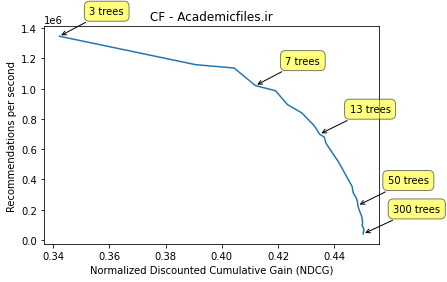

In [22]:
plt.plot(allndcgs3, allt3)
trees = [3, 5, 6, 7, 8, 9, 10, 12,13,14, 15, 20, 30, 35, 40, 45, 50, 60, 75, 100, 125, 150, 175, 200, 250,  300]
plt.ylabel("Recommendations per second")
plt.xlabel("Normalized Discounted Cumulative Gain (NDCG)")
plt.title('CF - ' + WEB_SITE_NAME)
for i in [0,3,8,16, 25]:
    plt.annotate(
            str(trees[i]) + " trees",
            xy=(allndcgs3[i], allt3[i]), xytext=(30, 30),
            textcoords='offset points', ha='left', va='top',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
plt.savefig(RESULTS_PATH + 'time_nDCG_CF_' + WEB_SITE_NAME + '.png', dpi=400)

content

In [23]:
Aknn_distances_brute_CB, Aknn_indices_brute_CB = sk_KNN_c(content_vec, items_itex, number_of_neighbours = 15)

ball_tree time: 0.06838488578796387


In [24]:
8723/22.65732431411743

384.99691662906696

In [25]:
allt = []
allndcgs = []
for i in tqdm(range(30)):
    tt = []
    accs = []
    ndcgs = []
    trees = [3, 5, 6, 7, 8, 9, 10, 12,13,14, 15, 20, 30, 35, 40, 45, 50, 60, 75, 100, 125, 150, 175, 200, 250,  300]
    for i in trees:
        Tannoy_indices_CB, Tannoy_distances_CB, Tduration_CB = get_annoy_results_c(item_content_map, number_of_trees = i, number_of_neighbours = 10)
        tt.append(8723/Tduration_CB)
        accs.append(calc_acc(Tannoy_indices_CB, Aknn_indices_brute_CB, 10))
        ndcgs.append(calc_nDCG(Tannoy_indices_CB, Aknn_indices_brute_CB, 13))
    allt.append(tt)
    allndcgs.append(ndcgs)
allt = np.array(allt)
allndcgs = np.array(allndcgs)


100%|██████████| 30/30 [00:34<00:00,  1.14s/it]


In [26]:
allt1 = np.mean(allt, axis = 0)
allndcgs1 = np.mean(allndcgs, axis = 0)

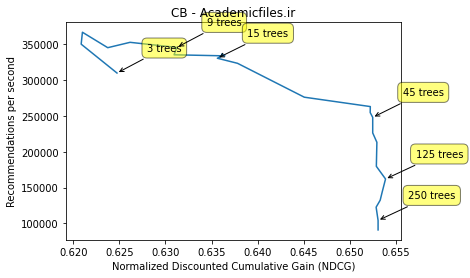

In [27]:
trees = [3, 5, 6, 7, 8, 9, 10, 12,13,14, 15, 20, 30, 35, 40, 45, 50, 60, 75, 100, 125, 150, 175, 200, 250,  300]
plt.plot(allndcgs1, allt1)
plt.ylabel("Recommendations per second")
plt.xlabel("Normalized Discounted Cumulative Gain (NDCG)")
plt.title('CB - ' + WEB_SITE_NAME)
for i in [0,5,10,15,20, 24]:
    plt.annotate(
            str(trees[i]) + " trees",
            xy=(allndcgs1[i], allt1[i]), xytext=(30, 30),
            textcoords='offset points', ha='left', va='top',
            bbox=dict(boxstyle='round, pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
plt.savefig(RESULTS_PATH + 'time_nDCG_CB_' + WEB_SITE_NAME + '.png', dpi=400)

## time - #features

In [28]:
alst = []
annoyt = []
annoyt150 = []
knnt = []
accs = []
ndcgs = []
features = [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300]

In [29]:
for i in features:
    print('features: ' + str(i))
    sparce_matrix5, implicit_matrix5, item_vectors5, user_vectors5, ALS_Time = \
    CFTrain(WEB_SITE_matrix, factors = i)
    alst.append(ALS_Time)

    now = time.time()
    annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors5, number_of_neighbours = 10)
    annoyt.append(time.time() - now)

    now = time.time()
    annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors5, number_of_trees = 150, number_of_neighbours = 10)
    annoyt150.append(time.time() - now)

    now = time.time()
    knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors5, number_of_neighbours = 10)
    knnt.append(time.time() - now)

    accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
    ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

features: 5
View matrix loaded in 0.10568857192993164 seconds.
Number of users which should be deleted: 7879
Number products which should be deleted: 75
Number of users which should be deleted: 4
Number products which should be deleted: 0
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 0.329465389251709 seconds.

ALS model is fitted in 0.27191972732543945 seconds.
Saving Data ...
ball_tree time: 0.004138946533203125
features: 10
View matrix loaded in 0.09145355224609375 seconds.
Number of users which should be deleted: 7879
Number products which should be deleted: 75
Number of users which should be deleted: 4
Number products which should be deleted: 0
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 0.3321497440338135 seconds.

ALS model is fitted in 0.4238603115081787 seconds.
Saving Data ...
ball_tree time: 0.004831790924072266
features: 15
View matri

ALS model is fitted in 167.40348434448242 seconds.
Saving Data ...
ball_tree time: 0.05754971504211426
features: 220
View matrix loaded in 0.08545541763305664 seconds.
Number of users which should be deleted: 7879
Number products which should be deleted: 75
Number of users which should be deleted: 4
Number products which should be deleted: 0
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 0.3218536376953125 seconds.

ALS model is fitted in 191.95553636550903 seconds.
Saving Data ...
ball_tree time: 0.05993843078613281
features: 240
View matrix loaded in 0.09178900718688965 seconds.
Number of users which should be deleted: 7879
Number products which should be deleted: 75
Number of users which should be deleted: 4
Number products which should be deleted: 0
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 0.3293578624725342 seconds.

ALS model is fitted in

In [30]:
print(alst)
print(annoyt)
print(annoyt150)
print(knnt)
print(accs)
print(ndcgs)

[0.27191829681396484, 0.4238588809967041, 0.6715633869171143, 0.6945550441741943, 1.280797004699707, 1.9176244735717773, 5.026611566543579, 5.053133964538574, 6.362088203430176, 10.04871678352356, 21.915299892425537, 30.364007472991943, 35.263739824295044, 84.3676176071167, 142.27766060829163, 138.29395580291748, 167.4034812450409, 191.9555332660675, 276.3365776538849, 383.4123303890228, 345.88293266296387, 381.8782706260681]
[0.056824684143066406, 0.04748702049255371, 0.07100677490234375, 0.042473554611206055, 0.03757977485656738, 0.04641366004943848, 0.06350564956665039, 0.06297612190246582, 0.06933999061584473, 0.06225705146789551, 0.07694196701049805, 0.06625676155090332, 0.06429457664489746, 0.07596635818481445, 0.07876992225646973, 0.0638878345489502, 0.03786826133728027, 0.05874800682067871, 0.06705713272094727, 0.07488584518432617, 0.07760763168334961, 0.08291935920715332]
[0.15188884735107422, 0.12977957725524902, 0.11488199234008789, 0.1101980209350586, 0.09974026679992676, 0

In [31]:
# for chetor
# alst = [6.15050196647644, 7.589384078979492, 9.98952865600586, 10.711763143539429, 14.620095014572144, 18.732149124145508, 84.2838044166565, 89.42482948303223, 114.60924625396729, 153.58080077171326, 328.83570289611816, 484.86647629737854, 618.9409790039062, 929.9091029167175, 1287.0432839393616, 1685.2656395435333, 2808.3832564353943, 3449.2337753772736, 4116.154020309448, 5639.494827508926, 6508.6048147678375]
# annoyt = [1.08254838, 0.96629797, 0.9242843 , 0.87962387, 0.85262046, 0.79565946, 0.77240711, 0.73983479, 0.71700769, 0.7067995 , 0.70250529, 0.70883131, 0.70684481, 0.73545814, 0.74710369, 0.78903913, 0.80155802, 0.86104798, 0.89263225, 0.96022302, 0.95924781, 0.98024781]
# annoyt150 = [3.197788953781128, 2.687863349914551, 2.7068495750427246, 2.370072841644287, 2.156468391418457, 2.2803003787994385, 2.090477705001831, 1.9102835655212402, 1.9289910793304443, 1.9350402355194092, 1.8130168914794922, 1.8827829360961914, 1.77535080909729, 1.9186785221099854, 1.7952370643615723, 1.8383240699768066, 1.7986578941345215, 1.9579110145568848, 2.0136091709136963, 2.144573926925659, 2.163679838180542, 2.163679838180542]
# knnt = [0.3063969612121582, 0.5551221370697021, 0.7591581344604492, 0.9750919342041016, 1.2589349746704102, 1.4075870513916016, 1.763763189315796, 1.9242370128631592, 2.3055875301361084, 2.7826828956604004, 4.749085426330566, 6.809983968734741, 8.50152063369751, 10.003107070922852, 11.503920078277588, 12.858023881912231, 14.28891658782959, 15.586156606674194, 16.799457788467407, 18.877679109573364, 19.313379764556885, 19.313379764556885]
# accs = [0.12793046063367425, 0.19506244648021587, 0.22571211607128433, 0.24652222383791383, 0.26537734477242986, 0.27297109527733343, 0.2814373192445026, 0.28823938086698014, 0.30185966102790296, 0.3160777470796375, 0.32956877191281725, 0.3423004216955068, 0.3587966328987123, 0.37096279062252596, 0.3799621928166352, 0.39052881585962873, 0.3979933110367893, 0.4029373273229606, 0.4112904528783546, 0.4174623947780847, 0.42290727545926027]
# ndcgs = [0.10767360998286381, 0.16470088519858192, 0.19102143484369105, 0.20831224714747743, 0.2241932091048414, 0.23058533948113838, 0.2378233423079659, 0.2433912837195122, 0.25485586396084026, 0.26644019343716063, 0.27805367676769965, 0.2886241523175816, 0.3026225286968232, 0.31262019959143855, 0.3204764464923836, 0.3292857822171983, 0.3357298780495747, 0.34013670324948375, 0.34733789792423037, 0.352562057177892, 0.35756566236263726]

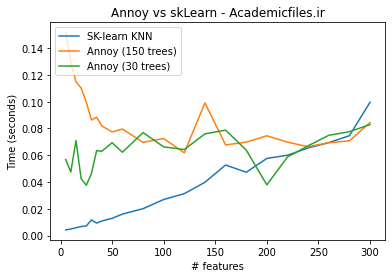

In [32]:
features = [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300]
plt.plot(features, knnt, label = 'SK-learn KNN')
plt.plot(features, annoyt150, label = 'Annoy (150 trees)')
plt.plot(features, annoyt, label = 'Annoy (30 trees)')
plt.title('Annoy vs skLearn - ' + WEB_SITE_NAME)
plt.xlabel('# features')
plt.ylabel('Time (seconds)')
plt.legend(loc="upper left")
plt.savefig(RESULTS_PATH + 'annoyVSsk2_' + WEB_SITE_NAME + '.png', dpi=400)

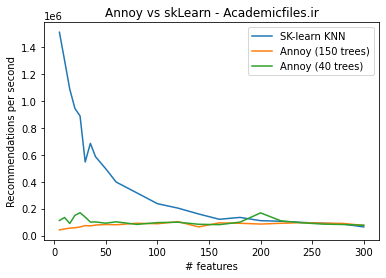

In [33]:
features = [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300]
plt.plot(features, 6378/np.array(knnt), label = 'SK-learn KNN')
plt.plot(features, 6378/np.array(annoyt150), label = 'Annoy (150 trees)')
plt.plot(features, 6378/np.array(annoyt), label = 'Annoy (40 trees)')
plt.title('Annoy vs skLearn - ' + WEB_SITE_NAME)
plt.xlabel('# features')
plt.ylabel('Recommendations per second')
plt.legend(loc="upper right")
plt.savefig(RESULTS_PATH + 'annoyVSsk_' + WEB_SITE_NAME + '.png', dpi=400)